<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


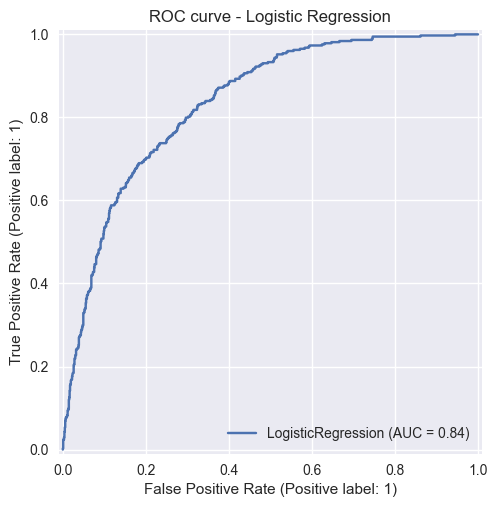

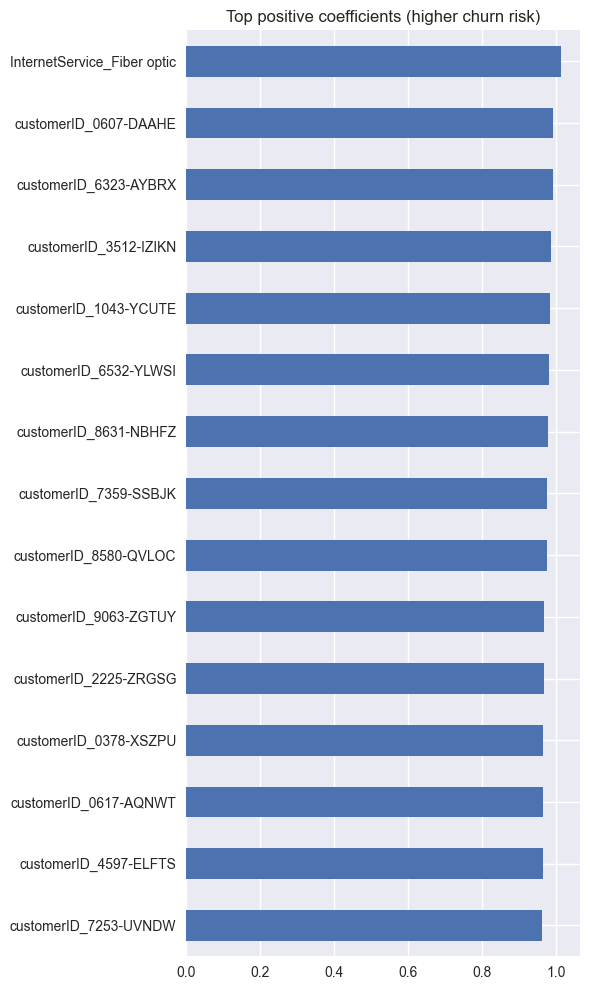

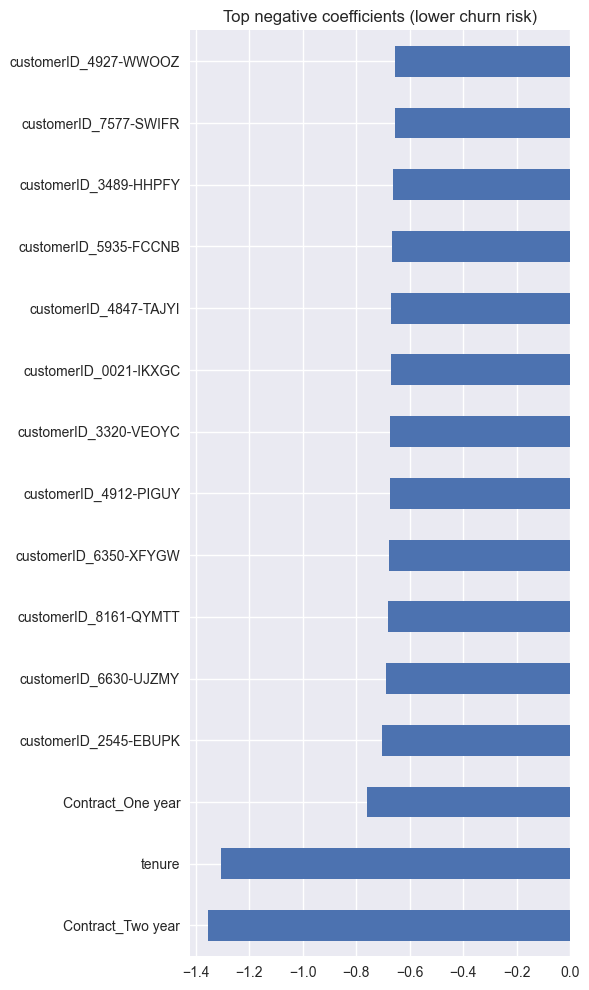

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)

plt.style.use("seaborn-v0_8")

# 1. Load cleaned data
df = pd.read_csv("../data/processed/telco_cleaned.csv")
df.head()
df.info()

# 2. One-hot encode categorical features
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", cat_cols)

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 3. Split features/target
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Identify numeric columns for scaling
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Scale numeric columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# 5. Train Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train_scaled, y_train)

# 6. Evaluate
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# ROC curve
RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test)
plt.title("ROC curve - Logistic Regression")
plt.savefig("../figures/logreg_roc.png", bbox_inches="tight")

# 7. Coefficients (feature importance)
coeffs = pd.Series(logreg.coef_[0], index=X_train_scaled.columns).sort_values()

plt.figure(figsize=(6,10))
coeffs.tail(15).plot(kind='barh')
plt.title("Top positive coefficients (higher churn risk)")
plt.tight_layout()
plt.savefig("../figures/logreg_top_positive_coeffs.png", bbox_inches="tight")

plt.figure(figsize=(6,10))
coeffs.head(15).plot(kind='barh')
plt.title("Top negative coefficients (lower churn risk)")
plt.tight_layout()
plt.savefig("../figures/logreg_top_negative_coeffs.png", bbox_inches="tight")

# Save probabilities for next notebook if you want
proba_df = pd.DataFrame({
    "Churn_true": y_test,
    "Churn_proba": y_proba
})
proba_df.to_csv("../data/processed/telco_logreg_test_proba.csv", index=False)
